<a href="https://colab.research.google.com/github/uzairname/OtsegoStoryProject/blob/main/experiments/Final_Analysis_Results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This notebook works best in Google Colab.
Click the link above to open this notebook in Colab. Otherwise, you must run `pip install -r requirements.txt`

If you would like to view the data, it is available at https://docs.google.com/spreadsheets/d/1WMoeCGweQA0xUtEwlK8R_XzRuZOgPqpHQDGWizb9slQ/

To be able to use Gemma, follow the instructions that show up after running the cell below to create a hugging face API key, and enter it when prompted.

If asked to add the token as a git credential, type n.

In [1]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
The token `huggingtoken` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `huggingtoken

In [2]:
!pip install -U bertopic bitsandbytes accelerate -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.7/354.7 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import pipeline
from datetime import timedelta
from sklearn.linear_model import LinearRegression
import numpy as np
import random
import re
from nltk.tokenize import sent_tokenize
from tqdm.notebook import tqdm
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

np.random.seed(42)
random.seed(42)

tqdm.pandas()

# -------------------------------
# 1. Data Loading & Preprocessing
# -------------------------------
nltk.download('vader_lexicon')

# Load CSV
csv_url = f'https://docs.google.com/spreadsheets/d/1WMoeCGweQA0xUtEwlK8R_XzRuZOgPqpHQDGWizb9slQ/export?format=csv'
df = pd.read_csv(csv_url)
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df[df['timestamp'].notnull()]  # Remove rows with invalid timestamps
df['content'] = df['content'].fillna("").astype(str)

nltk.download('punkt_tab')

def preprocess_text(text):

    # Replace newlines with a period and a space
    text = re.sub(r'[\r\n]+', '. ', text)

    # Tokenize into sentences
    sentences = sent_tokenize(text)

    # Filter out short sentences
    filtered_sentences = [s for s in sentences if len(s) >= 20]

    # Remove unwanted characters but preserve punctuation: , " . ? !
    cleaned_sentences = [
        re.sub(r'[^a-zA-Z0-9\s,.!?\"\'’]', '', s)
        for s in filtered_sentences
    ]

    # Optionally: lowercase everything for consistency
    cleaned_sentences = [s.lower() for s in cleaned_sentences]

    return ' '.join(cleaned_sentences)

# Remove "See more"
df['content'] = df['content'].str.replace("\nSee more", "", regex=False)

# Apply the preprocessing function to the content column
df['cleaned_content'] = df['content'].apply(preprocess_text)

# remove empty rows
df = df[df['cleaned_content'] != '']

# Inspect the first few rows of the new column
print(df[['content', 'cleaned_content']].head())

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


                                             content  \
3                I’ll be sure to take msu over there   
4  Outreach to people who grew up here but no lon...   
5  Whole house reverse osmosis water filter syste...   
7  Yeah,  don't you love it?! Why the hell are we...   
8  When I used to live in the city and had City W...   

                                     cleaned_content  
3                i’ll be sure to take msu over there  
4  outreach to people who grew up here but no lon...  
5  whole house reverse osmosis water filter syste...  
7  yeah,  don't you love it?! why the hell are we...  
8  when i used to live in the city and had city w...  


In [4]:
df[(df['content'].str.len() < 21)]

,timestamp,content,post_url,cleaned_content
152,2023-04-12 15:42:00,She lived in Allegan,https://www.facebook.com/groups/19969065872295...,she lived in allegan
227,2023-04-12 15:44:00,Praying for you Mary,https://www.facebook.com/groups/19969065872295...,praying for you mary
541,2020-04-12 15:52:00,Can you make public?,https://www.facebook.com/groups/19969065872295...,can you make public?
692,2019-04-13 16:04:00,Born and raised here,https://www.facebook.com/groups/19969065872295...,born and raised here
737,2019-04-13 16:05:00,Only a few chemicals,https://www.facebook.com/groups/19969065872295...,only a few chemicals
826,2019-04-13 16:08:00,Where is it located?,https://www.facebook.com/groups/19969065872295...,where is it located?
850,2019-04-13 16:08:00,Around $90 pre month,https://www.facebook.com/groups/19969065872295...,around 90 pre month


### Apply Sentiment Analysis

The following cell computes sentiment scores via BERT and Vader. It may take a few minutes

In [5]:
# -------------------------------
# 2. Sentiment Analysis: VADER
# -------------------------------
vader = SentimentIntensityAnalyzer()
df['vader_compound'] = df['content'].apply(lambda x: vader.polarity_scores(x)['compound'])

# -------------------------------
# 3. Sentiment Analysis: BERT
# -------------------------------
# Initialize a BERT sentiment-analysis pipeline.


# bert_pipeline = pipeline("text-classification", model="nlptown/bert-base-multilingual-uncased-sentiment")

# def get_bert_compound(text):
#     # Get the sentiment result (returns a list of dicts)
#     result = bert_pipeline(text)
#     # Extract the star rating from the label (e.g., "4 stars")
#     label = result[0]['label']
#     rating = int(label.split()[0])
#     # Map rating (1-5) to a compound score between -1 and 1:
#     # 1 -> -1.0, 2 -> -0.5, 3 -> 0.0, 4 -> 0.5, 5 -> 1.0
#     compound = (rating - 3) / 2.0
#     return compound


# Apply BERT sentiment analysis (this may take a bit, depending on the dataset size)
# df['bert_compound'] = df['content'].progress_apply(get_bert_compound)

# Load the sentiment analysis pipeline (uses a BERT-based model by default)
sentiment_pipeline = pipeline("sentiment-analysis")

# Apply BERT sentiment analysis (this may take a bit, depending on the dataset size)
results = sentiment_pipeline(df['content'].tolist(), batch_size=16)

compound_scores = [
    result['score'] if result['label'] == 'POSITIVE' else -result['score']
    for result in results
]

# Add the new column to the DataFrame
df['bert_compound'] = compound_scores



No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


In [36]:
vader_dist = pd.cut(df['vader_compound'], bins=[float('-inf'), -0.01, 0.01, float('inf')], labels=['negative', 'neutral', 'positive'], right=True).value_counts()
bert_dist = pd.cut(df['bert_compound'], bins=[float('-inf'), -0.7, 0.7, float('inf')], labels=['negative', 'neutral', 'positive'], right=True).value_counts()
print('Vader sentiment distribution')
print(vader_dist)
print('BERT sentiment distribution')
print(bert_dist)

Vader sentiment distribution
vader_compound
positive    352
neutral     266
negative    227
Name: count, dtype: int64
BERT sentiment distribution
bert_compound
negative    540
positive    284
neutral      21
Name: count, dtype: int64


In [ ]:
df['bert_compound'].value_counts()

# Fit Topic Model

The following cells train a topic model on the posts. It assigns a topic index to each post. We can then analyze the posts by topic, date, and sentiment.

In [6]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import HDBSCAN
from bertopic.representation import KeyBERTInspired
from umap import UMAP

model = BERTopic(
    embedding_model="all-MiniLM-L6-v2",
    top_n_words=10,
    min_topic_size=10,
    n_gram_range=(1, 2),
    vectorizer_model=CountVectorizer(ngram_range=(1, 2), stop_words="english"),
    representation_model=KeyBERTInspired(),
    hdbscan_model= HDBSCAN(min_cluster_size=20),
    umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine'),
    verbose=True,
    nr_topics=6,
)

topics, probs = model.fit_transform(df['cleaned_content'])
df['topic'] = topics


2025-04-20 21:27:33,946 - BERTopic - Embedding - Transforming documents to embeddings.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

2025-04-20 21:28:01,032 - BERTopic - Embedding - Completed ✓
2025-04-20 21:28:01,036 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-20 21:28:21,193 - BERTopic - Dimensionality - Completed ✓
2025-04-20 21:28:21,198 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-20 21:28:21,230 - BERTopic - Cluster - Completed ✓
2025-04-20 21:28:21,232 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-20 21:28:21,350 - BERTopic - Representation - Completed ✓
2025-04-20 21:28:21,352 - BERTopic - Topic reduction - Reducing number of topics
2025-04-20 21:28:21,371 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-20 21:28:23,879 - BERTopic - Representation - Completed ✓
2025-04-20 21:28:23,885 - BERTopic - Topic reduction - Reduced number of topics from 10 to 6


# Generate Topic Names

The following cells will use a language model to assign the topics short titles in natural language. This is a free, open source model from hugging face. It may take a minute to download the model.

In [7]:
from transformers import pipeline

# client = OpenAI()
# def chat(prompt):
#   response = client.responses.create(
#       model="gpt-4o-mini",
#       input=prompt
#   )
#.  return response.output_text

pipe = pipeline("text-generation", model="google/gemma-3-1b-it")

config.json:   0%|          | 0.00/899 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

Device set to use cpu


In [8]:
def chat(prompt):
  from transformers import pipeline

  messages = [
      {"role": "user", "content": prompt},
  ]
  output = pipe(messages)
  return output[0]['generated_text'][-1]['content']

def get_topic_info(model, topic_id, df, n_docs=10):
  topic_docs = df[df['topic']==topic_id]
  topic_docs = topic_docs.sample(min(n_docs, len(topic_docs)))
  keywords = ', '.join([i for i in model.generate_topic_labels(nr_words=5) if int(i.split('_')[0]) == topic_id][0].split('_')[1:])
  return topic_docs['content'].tolist(), keywords


In [9]:

topic_names = {}
for topic_id in list(set(model.topics_)):
  docs, keywords = get_topic_info(model, topic_id, df)

  docs_str = "\n".join(docs)

  prompt = docs_str + f"\n\nAbove are a subset of facebook posts that follow a common theme. The theme has the key words \"{keywords}\". Please come up with a title/label representing the subject of what people are discussing in 5 words or less. Be specific. Respond with just the label and nothing else."

  print(prompt)

  response = chat(prompt)
  print(response)

  topic_names[topic_id]=response.strip()

df['topic_name'] = df['topic'].map(topic_names)


Hi, the link above seems to be a downloadable pdf that doesn't have any extra info. Is there a better place to look and get sections and street addresses?
Does anybody know the location of the 120 homes that are getting city water?
What part of Miller Road did they do this.  East or West of 131?  I live on Miller Road East of 131.
Mary Zack
do you happen to have a map
Section 17;  when would the sludge have been dumped?   My family built in ‘53 and are still there.   No dumping happened there in 65 years.
Michigan has naturally high fluoride in groundwater anyways.
Tony clarified that he called and requested the testing.  False alarm.
Trident labs in holland. Will send you a kit at 250$
Are they testing in Plainwell, Otsego?
If thats true then the entire Camp Lejeune water contamination is a lie.  Just Google Camp Lejeune and water contamination.  The time range is crazy.  So not only do I have to worry about living right down the road from said paper mill in Otsego, I was…

Above are 

In [10]:
df['topic_name'].value_counts()

,count
topic_name,
Community Grief & Loss,255
Camp Water Contamination,252
Faith & Support,163
Cancer Survivor’s Grief,85
Toxic Accountability,53
Otsego Community Concern,37


# Figures

## Sentiment by topic

In [11]:
import plotly.express as px
# Determine mean sentiments by topic
sentiment_by_topic = df.groupby(['topic_name']).agg({'vader_compound': 'mean'}).reset_index()

fig = px.bar(
    sentiment_by_topic,
    x='topic_name',
    y='vader_compound',
    color='vader_compound',
    labels={'topic_name': 'Topic', 'vader_compound': "Mean Sentiment"},
    title='Mean Sentiment by Topic',
)

fig.show()

In [12]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Determine mean sentiment by topics over time
sentiment_by_topic_year = df.groupby(['topic_name', df['timestamp'].dt.year]).agg({'vader_compound': 'mean'})

sentiment_by_topic_year = sentiment_by_topic_year.reset_index()

# Create the Plotly line plot
fig = px.line(
    sentiment_by_topic_year,
    x='timestamp',
    y=['vader_compound'],
    color='topic_name',
    title='Mean Sentiment by Topic Over Time',
    labels={'timestamp': 'Year', 'value': 'Mean Sentiment', 'topic_name': 'Topic'},
)

fig.show()

In [37]:
import plotly.express as px

# Group by topic and year, then count the number of rows
volume_by_topic_year = df.groupby(['topic_name', df['timestamp'].dt.year]).size().reset_index(name='count')

# Rename the year column for clarity
volume_by_topic_year.rename(columns={'timestamp': 'year'}, inplace=True)

# Create the Plotly line plot
fig = px.line(
    volume_by_topic_year,
    x='year',
    y='count',
    color='topic_name',
    title='Volume of Posts by Topic Over Time',
    labels={'year': 'Year', 'count': 'Post Volume', 'topic_name': 'Topic'},
)

fig.show()


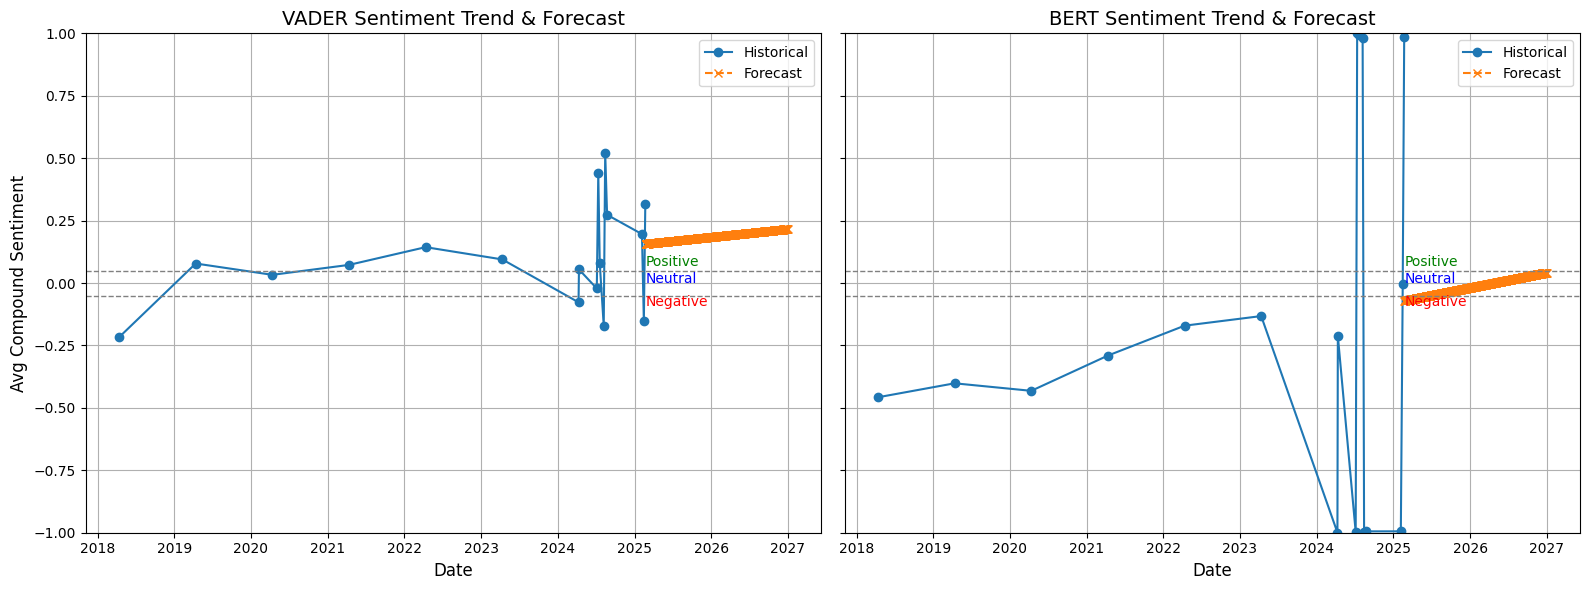

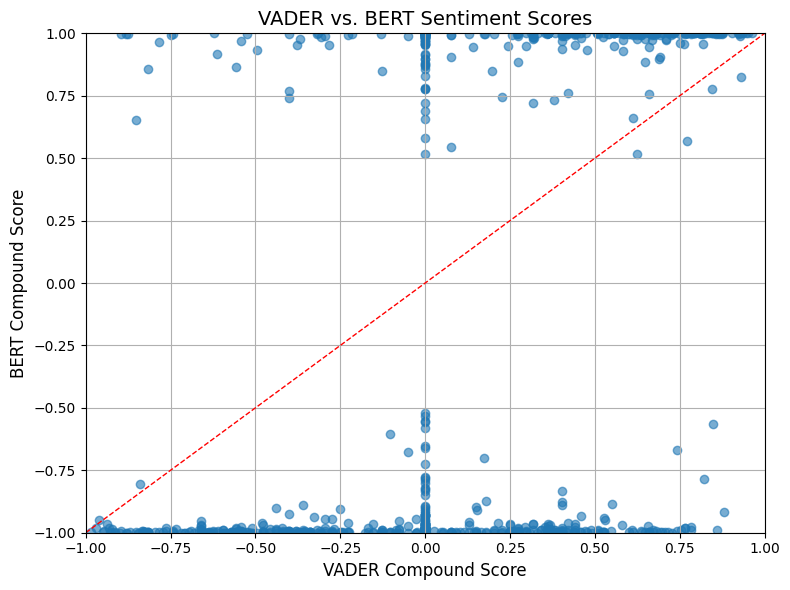

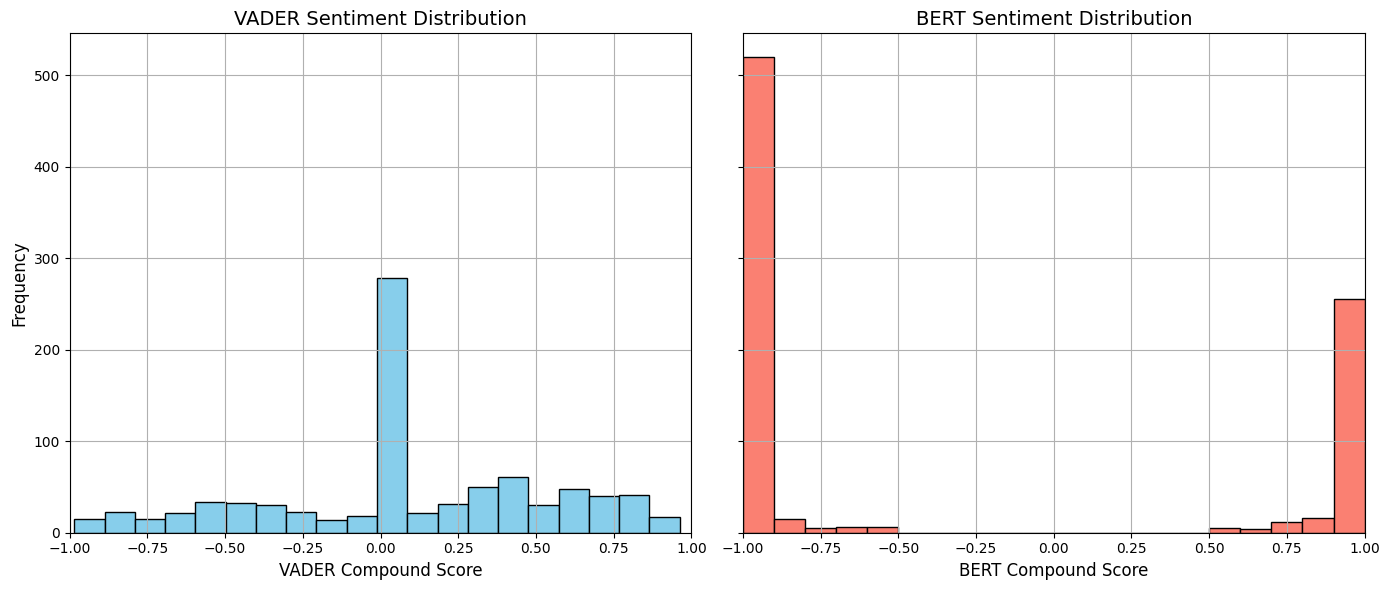

In [17]:
df['date'] = df['timestamp'].dt.date

# Aggregate daily average sentiment for VADER and BERT
daily_vader = df.groupby('date')['vader_compound'].mean().reset_index().rename(columns={'vader_compound': 'avg_compound'})
daily_bert = df.groupby('date')['bert_compound'].mean().reset_index().rename(columns={'bert_compound': 'avg_compound'})

# Forecast function using linear regression
def forecast_sentiment(daily_df):
    # Convert dates to ordinal numbers for regression
    daily_df['date_ordinal'] = pd.to_datetime(daily_df['date']).apply(lambda date: date.toordinal())
    X = daily_df['date_ordinal'].values.reshape(-1, 1)
    y = daily_df['avg_compound'].values
    model = LinearRegression()
    model.fit(X, y)

    # Forecast from the day after the last date until the end of 2026
    last_date = pd.to_datetime(daily_df['date'].max())
    future_dates = pd.date_range(start=last_date + timedelta(days=1), end=pd.Timestamp("2026-12-31"))
    future_ordinals = np.array([d.toordinal() for d in future_dates]).reshape(-1, 1)
    predicted = model.predict(future_ordinals)
    future_df = pd.DataFrame({'date': future_dates, 'predicted_compound': predicted})
    return future_df

future_vader = forecast_sentiment(daily_vader)
future_bert = forecast_sentiment(daily_bert)

# -------------------------------
# 5. Visualization
# -------------------------------

# Figure 1: Trend Plots (side-by-side) for VADER and BERT with Forecasts
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# VADER Plot
axs[0].plot(daily_vader['date'], daily_vader['avg_compound'], marker='o', label='Historical')
axs[0].plot(future_vader['date'], future_vader['predicted_compound'], marker='x', linestyle='--', label='Forecast')
axs[0].set_xlabel('Date', fontsize=12)
axs[0].set_ylabel('Avg Compound Sentiment', fontsize=12)
axs[0].set_title('VADER Sentiment Trend & Forecast', fontsize=14)
axs[0].set_ylim(-1, 1)
axs[0].axhline(y=0.05, color='gray', linestyle='--', linewidth=1)
axs[0].axhline(y=-0.05, color='gray', linestyle='--', linewidth=1)
axs[0].grid(True)
axs[0].legend(fontsize=10)
axs[0].text(daily_vader['date'].iloc[-1], 0.07, 'Positive', color='green', fontsize=10)
axs[0].text(daily_vader['date'].iloc[-1], 0.00, 'Neutral', color='blue', fontsize=10)
axs[0].text(daily_vader['date'].iloc[-1], -0.09, 'Negative', color='red', fontsize=10)

# BERT Plot
axs[1].plot(daily_bert['date'], daily_bert['avg_compound'], marker='o', label='Historical')
axs[1].plot(future_bert['date'], future_bert['predicted_compound'], marker='x', linestyle='--', label='Forecast')
axs[1].set_xlabel('Date', fontsize=12)
axs[1].set_title('BERT Sentiment Trend & Forecast', fontsize=14)
axs[1].set_ylim(-1, 1)
axs[1].axhline(y=0.05, color='gray', linestyle='--', linewidth=1)
axs[1].axhline(y=-0.05, color='gray', linestyle='--', linewidth=1)
axs[1].grid(True)
axs[1].legend(fontsize=10)
axs[1].text(daily_bert['date'].iloc[-1], 0.07, 'Positive', color='green', fontsize=10)
axs[1].text(daily_bert['date'].iloc[-1], 0.00, 'Neutral', color='blue', fontsize=10)
axs[1].text(daily_bert['date'].iloc[-1], -0.09, 'Negative', color='red', fontsize=10)

plt.tight_layout()
plt.show()

# Figure 2: Scatter Plot Comparing VADER vs. BERT for Each Post
plt.figure(figsize=(8, 6))
plt.scatter(df['vader_compound'], df['bert_compound'], alpha=0.6)
plt.xlabel('VADER Compound Score', fontsize=12)
plt.ylabel('BERT Compound Score', fontsize=12)
plt.title('VADER vs. BERT Sentiment Scores', fontsize=14)
plt.grid(True)
lims = [-1, 1]
plt.plot(lims, lims, 'r--', linewidth=1)  # Diagonal reference line
plt.xlim(lims)
plt.ylim(lims)
plt.tight_layout()
plt.show()

# Figure 3: Histograms of Sentiment Distributions for VADER and BERT
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

ax1.hist(df['vader_compound'], bins=20, color='skyblue', edgecolor='black')
ax1.set_title('VADER Sentiment Distribution', fontsize=14)
ax1.set_xlabel('VADER Compound Score', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_xlim(-1, 1)
ax1.grid(True)

ax2.hist(df['bert_compound'], bins=20, color='salmon', edgecolor='black')
ax2.set_title('BERT Sentiment Distribution', fontsize=14)
ax2.set_xlabel('BERT Compound Score', fontsize=12)
ax2.set_xlim(-1, 1)
ax2.grid(True)

plt.tight_layout()
plt.show()

# -------------------------------
# 6. Summary Statistics & Analysis Output
# -------------------------------

<ipython-input-18-33aca2bd6e81>:18: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.

<ipython-input-18-33aca2bd6e81>:24: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



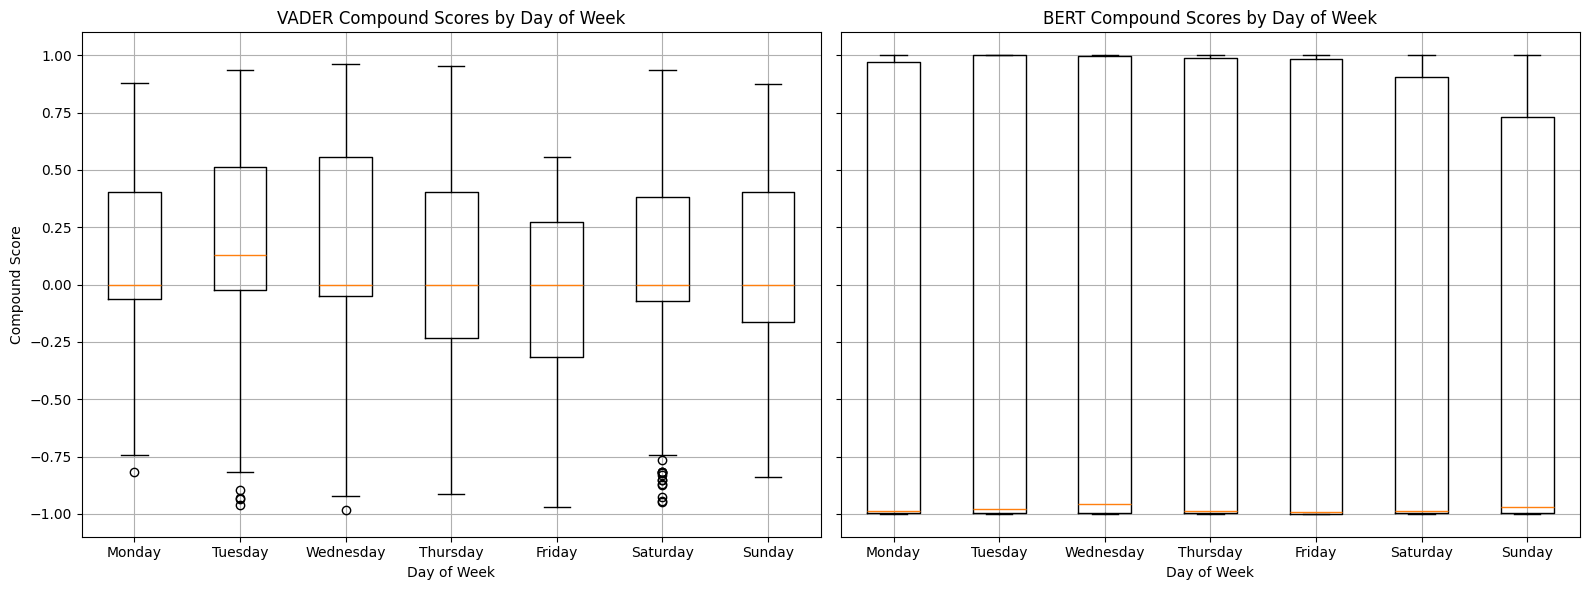

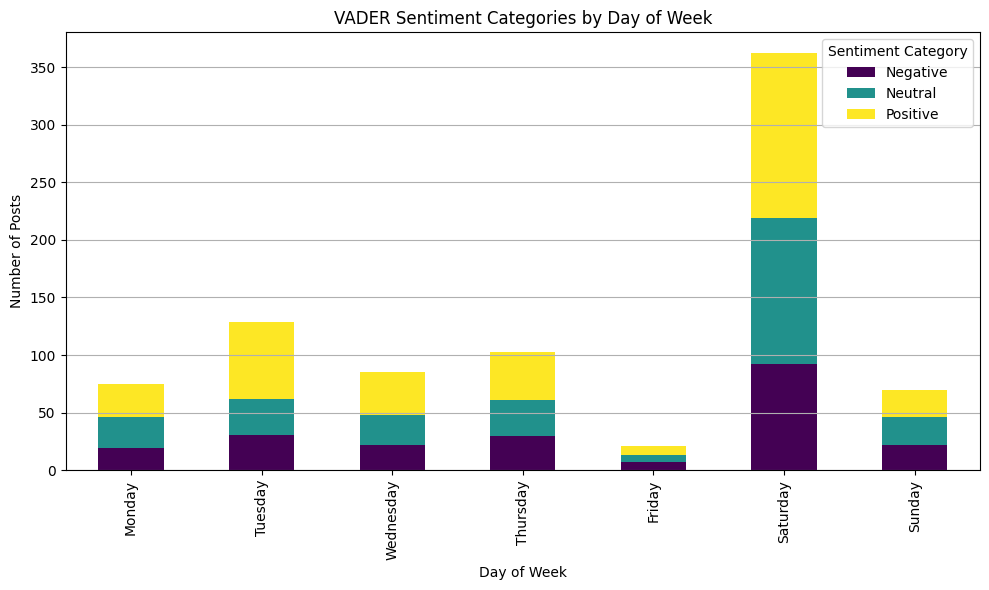

Summary Statistics:
Total posts analyzed: 845
Average VADER compound score: 0.079
Average BERT compound score: -0.304
Standard Deviation VADER compound score: 0.452
Standard Deviation BERT compound score: 0.926

VADER Sentiment Category Counts:
vader_compound
Positive    350
Neutral     272
Negative    223
Name: count, dtype: int64

BERT Sentiment Category Counts:
bert_compound
Negative    552
Positive    293
Name: count, dtype: int64

Correlation between VADER and BERT compound scores: 0.463


In [18]:
# Additional Visualizations

import matplotlib.pyplot as plt

# --- Visualization 4: Box Plots of VADER and BERT Compound Scores by Day of Week ---

# Create a 'day_of_week' column in the DataFrame with proper ordering
days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df['day_of_week'] = pd.Categorical(df['timestamp'].dt.day_name(), categories=days_order, ordered=True)

# Prepare the data lists for each day for both VADER and BERT scores
vader_box_data = [df.loc[df['day_of_week'] == day, 'vader_compound'].dropna() for day in days_order]
bert_box_data = [df.loc[df['day_of_week'] == day, 'bert_compound'].dropna() for day in days_order]

# Create side-by-side box plots
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

axs[0].boxplot(vader_box_data, labels=days_order)
axs[0].set_title("VADER Compound Scores by Day of Week")
axs[0].set_xlabel("Day of Week")
axs[0].set_ylabel("Compound Score")
axs[0].grid(True)

axs[1].boxplot(bert_box_data, labels=days_order)
axs[1].set_title("BERT Compound Scores by Day of Week")
axs[1].set_xlabel("Day of Week")
axs[1].grid(True)

plt.tight_layout()
plt.show()


# --- Visualization 5: Stacked Bar Chart of VADER Sentiment Categories by Day of Week ---

# Define a helper function to assign sentiment categories for VADER
def categorize(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the function to create a new category column for VADER scores
df['vader_category'] = df['vader_compound'].apply(categorize)

# Create a pivot table: counts of sentiment categories by day of week
pivot = df.groupby('day_of_week')['vader_category'].value_counts().unstack().fillna(0).loc[days_order]

# Plot a stacked bar chart for the VADER sentiment categories by day
pivot.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title("VADER Sentiment Categories by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Posts")
plt.legend(title="Sentiment Category")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

print("Summary Statistics:")

total_posts = len(df)
print(f"Total posts analyzed: {total_posts}")

avg_vader = df['vader_compound'].mean()
avg_bert = df['bert_compound'].mean()
std_vader = df['vader_compound'].std()
std_bert = df['bert_compound'].std()

print(f"Average VADER compound score: {avg_vader:.3f}")
print(f"Average BERT compound score: {avg_bert:.3f}")
print(f"Standard Deviation VADER compound score: {std_vader:.3f}")
print(f"Standard Deviation BERT compound score: {std_bert:.3f}")

# Define a helper function to assign a sentiment category
def categorize(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

vader_categories = df['vader_compound'].apply(categorize)
bert_categories = df['bert_compound'].apply(categorize)

vader_counts = vader_categories.value_counts()
bert_counts = bert_categories.value_counts()

print("\nVADER Sentiment Category Counts:")
print(vader_counts)
print("\nBERT Sentiment Category Counts:")
print(bert_counts)

corr = df['vader_compound'].corr(df['bert_compound'])
print(f"\nCorrelation between VADER and BERT compound scores: {corr:.3f}")

## Summary Statistics:

- **Total posts analyzed**: 845  
- **Average VADER compound score**: 0.079  
- **Average BERT compound score**: -0.304  
- **Standard Deviation VADER compound score**: 0.452  
- **Standard Deviation BERT compound score**: 0.926  

---

### VADER Sentiment Category Counts:

| Sentiment | Count |
|-----------|-------|
| Positive  | 350   |
| Neutral   | 272   |
| Negative  | 223   |

---

### BERT Sentiment Category Counts:

| Sentiment | Count |
|-----------|-------|
| Negative  | 552   |
| Positive  | 293   |

## Insights & Recommendations
- **Context Matters:**  
  The slightly positive averages hide variability. BERT’s higher negative count may better reflect community distress.
  
- **Multiple Methods:**  
  Using both VADER and BERT provides a fuller picture. Consider fine-tuning BERT on domain-specific data for improved accuracy.

- **Additional Visualizations:**  
  - **Heatmaps/Calendar Plots:** Identify periods with heightened negative sentiment.  
  - **Topic Modeling:** Use LDA to link themes (e.g., water quality, cancer) with sentiment trends.  
  - **Event Annotations:** Overlay key community events on trend graphs to contextualize shifts in sentiment.

## Conclusion
While overall sentiment appears slightly positive, the variability and methodological differences (especially BERT’s detection of more negative sentiment) suggest that the community's emotional response is more nuanced and polarized. This underscores the need for a combined quantitative and qualitative approach to fully capture the community's experiences, particularly given the serious issues of water quality and health.

